## Best classification model

In this notebook, I will use a Loan data of customers whose loans are already paid off or defaulted to train 4 different models of classification mentioned below and compare their accuracy on a test data.

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


Lets first load required libraries:

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-10-22 22:53:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2018-10-22 22:53:34 (252 KB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()


PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn 
!conda install -c anaconda seaborn -y

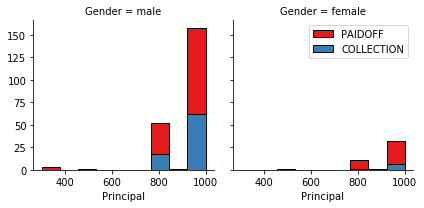

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

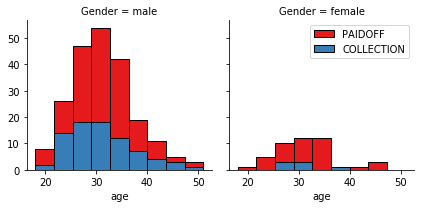

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

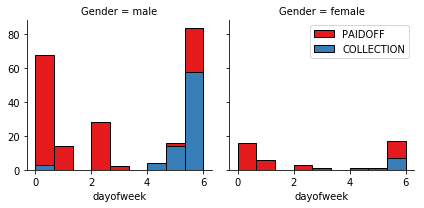

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less than day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

# Lets replace 'COLLECTION' with 0 and 'PAIDOFF' with 1

In [20]:
df['loan_status'].replace(to_replace = ['COLLECTION','PAIDOFF'], value = [0 , 1], inplace = True)

In [21]:
df

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_status_cate
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,None
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,None
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,None
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,None
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,None
5,7,7,1,1000,30,2016-09-09,2016-10-08,36,college,0,4,1,None
6,8,8,1,1000,30,2016-09-09,2016-10-08,28,college,0,4,1,None
7,9,9,1,800,15,2016-09-10,2016-09-24,26,college,0,5,1,None
8,10,10,1,300,7,2016-09-10,2016-09-16,29,college,0,5,1,None
9,11,11,1,1000,15,2016-09-10,2016-10-09,39,High School or Below,0,5,1,None


In [22]:
y = df['loan_status']
y[0:30]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
Name: loan_status, dtype: int64

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [23]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

# K Nearest Neighbor(KNN)
Notice: We will find the best k to build the model with the best accuracy.  


In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 4)
print('Training set size:', X_train.shape, y_train.shape)
print('Tets set size', X_test.shape, y_test.shape)


Training set size: (276, 8) (276,)
Tets set size (70, 8) (70,)


In [25]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 4).fit(X_train,y_train)
neigh
y_hat = neigh.predict(X_test)

In [26]:
from sklearn import metrics
print('Train set accuracy:', metrics.accuracy_score(y_train, neigh.predict(X_train)))
print('Test set accuracy:', metrics.accuracy_score(y_test, neigh.predict(X_test)))

Train set accuracy: 0.815217391304
Test set accuracy: 0.685714285714


In [27]:
K = 20
mean_acc = np.zeros((K-1))
for i in range(1,K):
    #print(i)
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    mean_acc[i-1] = metrics.accuracy_score(y_test,neigh.predict(X_test))
    
mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429,  0.75714286,  0.75714286,  0.67142857,
        0.7       ,  0.72857143,  0.7       ,  0.7       ,  0.68571429,
        0.72857143,  0.72857143,  0.72857143,  0.7       ])

Text(0,0.5,'Accuracy Score')

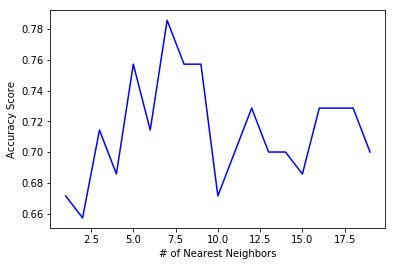

In [28]:
plt.plot(range(1,K), mean_acc, 'b')
plt.xlabel('# of Nearest Neighbors')
plt.ylabel('Accuracy Score')

In [30]:
Accuracy_scr = pd.Series(mean_acc)
#print(K1)
#K_Acc = pd.concat([K1,mean_acc], axis=1)
print('K with max mean_accuracy score',np.max(Accuracy_scr), 'is', np.argmax(Accuracy_scr) + 1 )

K with max mean_accuracy score 0.785714285714 is 7


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


# Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
loantree = DecisionTreeClassifier( criterion = 'entropy', max_depth = 4)
loantree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
y_hattree = loantree.predict(X_test)

In [47]:
print('Train set accuracy:', metrics.accuracy_score(y_train, loantree.predict(X_train)))
print('Test set accuracy:', metrics.accuracy_score(y_test, loantree.predict(X_test)))

Train set accuracy: 0.746376811594
Test set accuracy: 0.614285714286


In [48]:
d = 20
mean_acc_tree = np.zeros((d-1))
for n in range(1,d):
    #print(i)
    loantree = DecisionTreeClassifier( criterion = 'entropy', max_depth = n).fit(X_train,y_train)
    
    mean_acc_tree[n-1] = metrics.accuracy_score(y_test,loantree.predict(X_test))
    
mean_acc_tree

array([ 0.78571429,  0.78571429,  0.61428571,  0.61428571,  0.64285714,
        0.77142857,  0.75714286,  0.75714286,  0.65714286,  0.7       ,
        0.68571429,  0.71428571,  0.7       ,  0.72857143,  0.74285714,
        0.7       ,  0.7       ,  0.7       ,  0.7       ])

[ 0.78571429  0.78571429  0.61428571  0.61428571  0.64285714  0.77142857
  0.75714286  0.75714286  0.65714286  0.7         0.68571429  0.71428571
  0.7         0.72857143  0.74285714  0.7         0.7         0.7         0.7       ]
Depth with max mean_accuracy score 0.771428571429 is 6


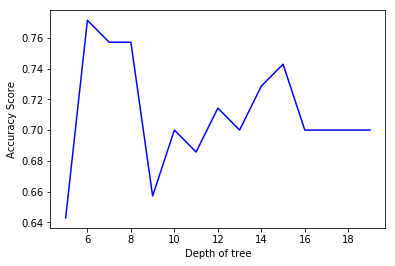

In [49]:
plt.plot(range(5,d),mean_acc_tree[4:],'b')
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy Score')
print(mean_acc_tree)
print('Depth with max mean_accuracy score',np.max(mean_acc_tree[4:]), 'is', np.argmax(mean_acc_tree[4:]) + 5 )

# Showing the plot of tree depth vs Accuracy score from tree depth 5 and onwards because lower depths won't categorise the data much

# Support Vector Machine

In [50]:
from sklearn import svm
loan_svm = svm.SVC(kernel = 'rbf').fit(X_train,y_train)


In [51]:
y_hat_svm = loan_svm.predict(X_test)

In [52]:
print('Train set accuracy:', metrics.accuracy_score(y_train, loan_svm.predict(X_train)))
print('Test set accuracy:', metrics.accuracy_score(y_test, loan_svm.predict(X_test)))

Train set accuracy: 0.782608695652
Test set accuracy: 0.742857142857


In [53]:
methodsvm = ['linear', 'poly', 'rbf', 'sigmoid']
acc_svm = np.zeros((len(methodsvm)))
for m,meth in enumerate(methodsvm):
    loan_svm1 = svm.SVC(kernel = meth).fit(X_train,y_train)
    acc_svm[m] = metrics.accuracy_score(y_test,loan_svm1.predict(X_test))
    print(meth , acc_svm[m])
acc_svm
    

linear 0.785714285714
poly 0.771428571429
rbf 0.742857142857
sigmoid 0.742857142857


array([ 0.78571429,  0.77142857,  0.74285714,  0.74285714])

([<matplotlib.axis.XTick at 0x7f02e72e2d30>,
 <a list of 4 Text xticklabel objects>)

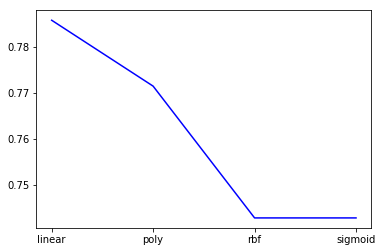

In [55]:
plt.plot(range(len(methodsvm)),acc_svm,'b')
plt.xticks(range(len(methodsvm)), methodsvm)
# Since linear kernel gives most accuracy, we'll use that for the new test set

# Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix
loanLR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
loanLR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
y_hat_lr = loanLR.predict(X_test)
y_hat_pr = loanLR.predict_proba(X_test)
print(y_hat_lr)

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


In [58]:
from sklearn.metrics import log_loss
log_loss(y_test, y_hat_pr)

0.57722876094796538

# Model Evaluation using Test set

In [59]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [60]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-10-22 23:38:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2018-10-22 23:38:37 (536 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [61]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [62]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [63]:
test_df['Gender'].replace(to_replace=['male', 'female'], value = [0,1], inplace = True)

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0


In [64]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [65]:
Ftest = test_df[['Principal', 'terms', 'age','Gender', 'weekend']]

Ftest = pd.concat([Ftest,(pd.get_dummies(test_df['education']))], axis = 1)
Ftest.drop(['Master or Above'], axis = 1, inplace  = True)

Ftest.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [66]:
y_test_new = test_df['loan_status'].values

In [67]:
y_test_new[0:10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [68]:
test_df['loan_status_cate']= test_df['loan_status'].replace(to_replace = ['COLLECTION','PAIDOFF'], value = [0,1])

In [69]:
test_df

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_status_cate
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0,1
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1,1
5,37,37,PAIDOFF,700,15,2016-09-11,2016-09-25,33,High School or Below,0,6,1,1
6,38,38,PAIDOFF,1000,15,2016-09-11,2016-09-25,24,college,0,6,1,1
7,48,48,PAIDOFF,1000,30,2016-09-11,2016-10-10,32,Bechalor,0,6,1,1
8,50,50,PAIDOFF,800,15,2016-09-11,2016-09-25,27,college,1,6,1,1
9,61,61,PAIDOFF,1000,15,2016-09-11,2016-09-25,37,college,0,6,1,1


In [70]:
y_test_new = test_df['loan_status_cate'].values

In [71]:
y_test_new[0:5]

array([1, 1, 1, 1, 1])

In [72]:
X_test_new= preprocessing.StandardScaler().fit(X).transform(Ftest)
X_test_new

array([[  1.00000000e+03,   3.00000000e+01,   5.00000000e+01,
          1.00000000e+00,  -8.21436689e-17,   1.00000000e+00,
         -8.21436689e-17,   0.00000000e+00],
       [  3.00000000e+02,   7.00000000e+00,   3.50000000e+01,
          4.87728034e-17,   1.00000000e+00,   5.13397930e-18,
         -8.21436689e-17,   0.00000000e+00],
       [  1.00000000e+03,   3.00000000e+01,   4.30000000e+01,
          1.00000000e+00,   1.00000000e+00,   5.13397930e-18,
          1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+03,   3.00000000e+01,   2.60000000e+01,
          4.87728034e-17,   1.00000000e+00,   5.13397930e-18,
         -8.21436689e-17,   1.00000000e+00],
       [  8.00000000e+02,   1.50000000e+01,   2.90000000e+01,
          4.87728034e-17,   1.00000000e+00,   1.00000000e+00,
         -8.21436689e-17,   0.00000000e+00],
       [  7.00000000e+02,   1.50000000e+01,   3.30000000e+01,
          4.87728034e-17,   1.00000000e+00,   5.13397930e-18,
          1.00000000e+00,   0.0

In [73]:
# For kNN
#using neighbors  =  7 as it gave the max accuracy during simulation
neigh7 = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)

print('f1_score is:', f1_score(y_test_new, neigh7.predict(X_test_new), average='weighted'))
print('jaccard_similarity is:',jaccard_similarity_score(y_test_new, neigh7.predict(X_test_new)))

f1_score is: 0.630417651694
jaccard_similarity is: 0.740740740741


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
# for Decision tree
# using depth = 6, as it gives max accuracy here
loantree6 = DecisionTreeClassifier( criterion = 'entropy', max_depth = 6).fit(X_train,y_train)

print('f1_score is:', f1_score(y_test_new, loantree6.predict(X_test_new), average='weighted'))
print('jaccard_similarity is:',jaccard_similarity_score(y_test_new, loantree6.predict(X_test_new)))


f1_score is: 0.725253407052
jaccard_similarity is: 0.722222222222


In [75]:
# for SVM , lets use the linear kernel since it was most accurate
loansvm_lin = svm.SVC(kernel = 'linear').fit(X_train,y_train)
print('f1_score is:', f1_score(y_test_new, loansvm_lin.predict(X_test_new), average='weighted'))
print('jaccard_similarity is:',jaccard_similarity_score(y_test_new, loansvm_lin.predict(X_test_new)))

f1_score is: 0.630417651694
jaccard_similarity is: 0.740740740741


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
# for Logistic regression

print('f1_score is:', f1_score(y_test_new, loanLR.predict(X_test_new), average='weighted'))
print('jaccard_similarity is:',jaccard_similarity_score(y_test_new, loanLR.predict(X_test_new)))
print('log loss is :', log_loss(y_test_new, loanLR.predict_proba(X_test_new)))


f1_score is: 0.106753812636
jaccard_similarity is: 0.259259259259
log loss is : 23.1055327627


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
tab = {'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'], 'Jaccard': [0.74,0.72,0.74, 0.26],
        'F1=Score':[0.63,0.73,0.63,0.10] , 'LogLoss':['NA','NA','NA',23.105]}

Report = pd.DataFrame(data = tab)
Report

,Algorithm,F1=Score,Jaccard,LogLoss
0,KNN,0.63,0.74,NA
1,Decision Tree,0.73,0.72,NA
2,SVM,0.63,0.74,NA
3,Logistic Regression,0.10,0.26,23.105
